# Proyecto 2 - HDT 9 

Diego García 22404<br>
César López 22535 <br>

GitHub: https://github.com/DiegoGarV/HDT8-DM 

In [38]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [19]:
train = pd.read_csv("train.csv")

X = train.drop(columns=["SalePrice"])
y = train["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 80)
(292, 80)
(1168,)
(292,)


In [20]:
categorical_columns_selector = selector(dtype_include=object)
numerical_columns_selector = selector(dtype_exclude=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

numerical_imputer = SimpleImputer(strategy='constant', fill_value=0)
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unavailable')

print(categorical_columns)
print(numerical_columns)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '

In [21]:
mean_price = train['SalePrice'].mean()
std_price = train['SalePrice'].std()

low_price = mean_price - std_price
mid_price = mean_price + std_price

def categorizar_casas(precio):
    if precio <= low_price:
        return "Barata"
    elif precio <= mid_price:
        return "Normal"
    else:
        return "Cara"

train['Categoria'] = train['SalePrice'].apply(categorizar_casas)
columnas_interes = ['OverallQual', 'GrLivArea', 'YearBuilt', 'YearRemodAdd',  'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea']

X_clf = train[columnas_interes]
y_clf = train["Categoria"]
df_clf = pd.concat([X_clf, y_clf], axis=1)

train['Categoria'].value_counts()

Categoria
Normal    1145
Cara       191
Barata     124
Name: count, dtype: int64

In [22]:
X_clf.describe()

,OverallQual,GrLivArea,YearBuilt,YearRemodAdd,TotalBsmtSF,TotRmsAbvGrd,GarageArea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1971.267808,1984.865753,1057.429452,6.517808,472.980137
std,1.382997,525.480383,30.202904,20.645407,438.705324,1.625393,213.804841
min,1.000000,334.000000,1872.000000,1950.000000,0.000000,2.000000,0.000000
25%,5.000000,1129.500000,1954.000000,1967.000000,795.750000,5.000000,334.500000
50%,6.000000,1464.000000,1973.000000,1994.000000,991.500000,6.000000,480.000000
75%,7.000000,1776.750000,2000.000000,2004.000000,1298.250000,7.000000,576.000000
max,10.000000,5642.000000,2010.000000,2010.000000,6110.000000,14.000000,1418.000000


Para este paso, al haber cargado los datos al igual ya tienen un preprosesamiento previo que elimina muchas impuresas de los datos como los datos nulos y crea los pipelines para manejar los datos. Sin embargo, aún queda el balanceo de las clases, ya que en el conteo de la variable categoría vemos que tenemos muchos más datos de las casas con precio normal que de aquellas con precios caros o baratos. Además, también es importante normalizar las variables, ya que cada una usa una medida distinta y esto puede hacer que algunas tengan más peso que otras, sesgando el modelo. 

In [27]:
# Balanceo

baratas = df_clf[df_clf["Categoria"] == "Barata"]
caras = df_clf[df_clf["Categoria"] == "Cara"]
normales = df_clf[df_clf["Categoria"] == "Normal"]

normales_downsampled = resample(normales, replace=False, n_samples=len(baratas), random_state=42)

caras_downsampled = resample(caras, replace=False, n_samples=len(baratas), random_state=42)

df_balanceado = pd.concat([baratas, caras_downsampled, normales_downsampled])

df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

X_clf_bal = df_balanceado[columnas_interes]
y_clf_bal = df_balanceado["Categoria"]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf_bal, y_clf_bal, test_size=0.2, random_state=42)

df_balanceado['Categoria'].value_counts()

Categoria
Normal    124
Barata    124
Cara      124
Name: count, dtype: int64

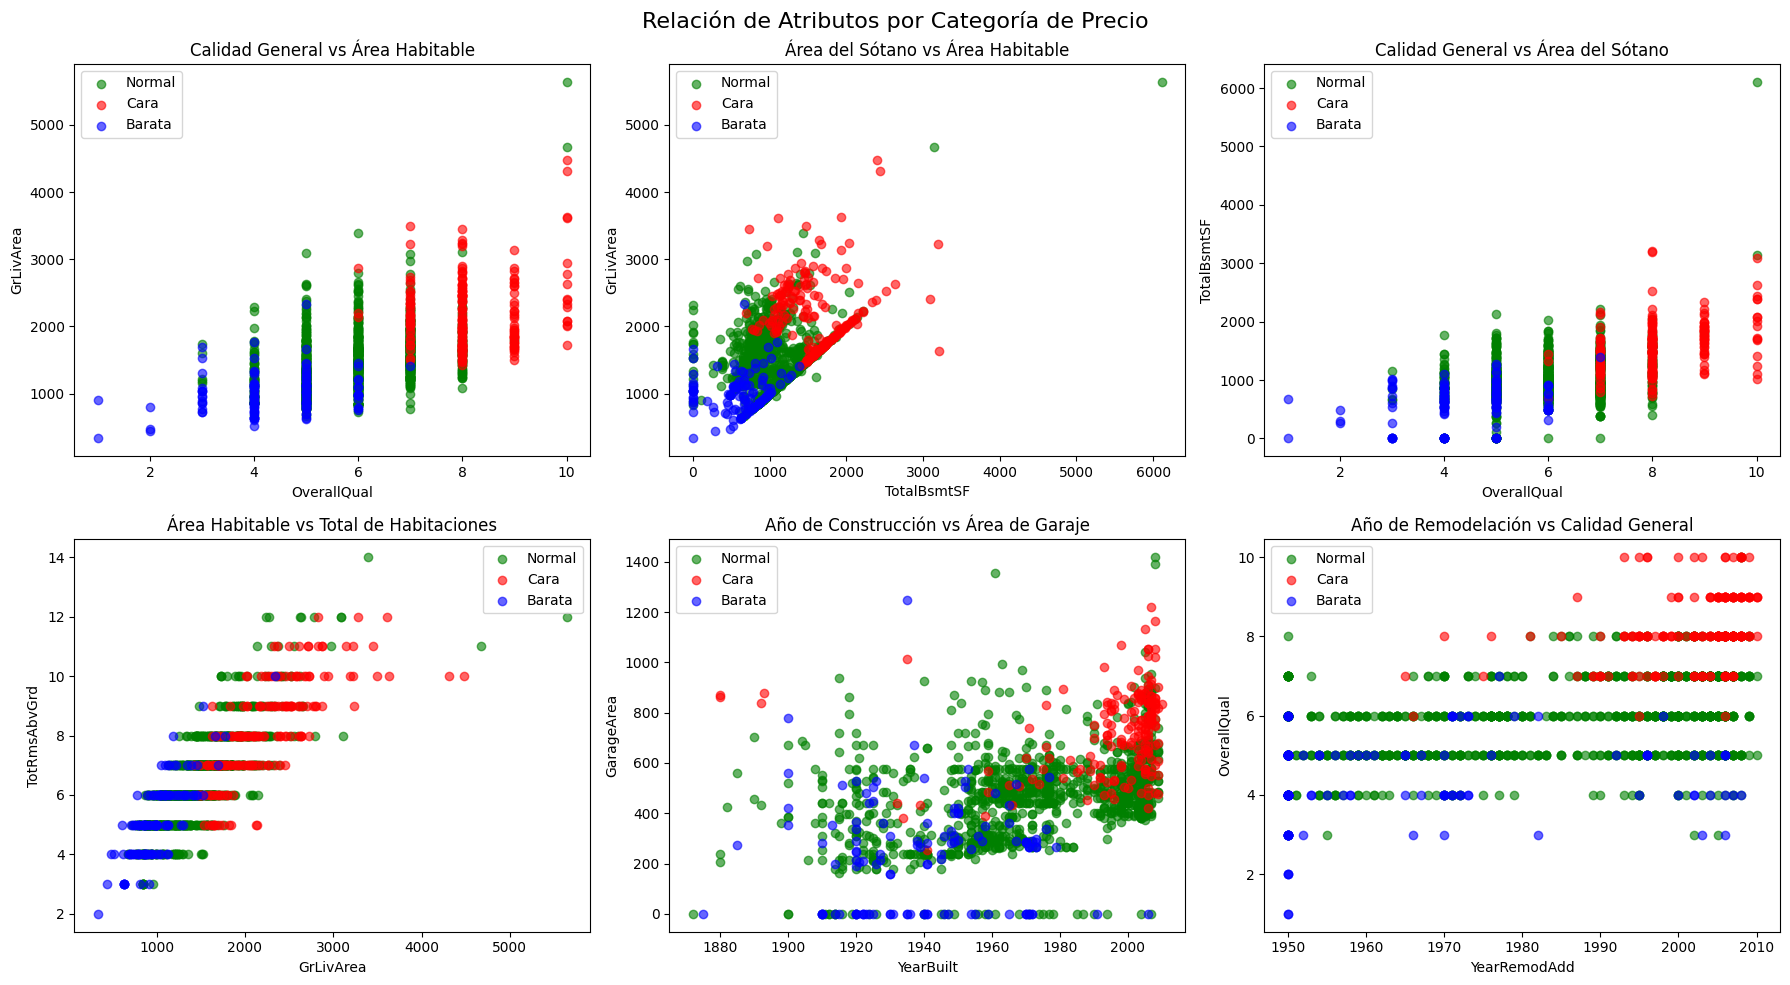

In [49]:
categoria_colores = {
    'Barata': 'blue',
    'Normal': 'green',
    'Cara': 'red'
}

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Relación de Atributos por Categoría de Precio', fontsize=16)

# Gráfico 1: OverallQual vs GrLivArea
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[0, 0].scatter(subset['OverallQual'], subset['GrLivArea'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[0, 0].set_xlabel('OverallQual')
axs[0, 0].set_ylabel('GrLivArea')
axs[0, 0].set_title('Calidad General vs Área Habitable')
axs[0, 0].legend()

# Gráfico 2: TotalBsmtSF vs GrLivArea
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[0, 1].scatter(subset['TotalBsmtSF'], subset['GrLivArea'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[0, 1].set_xlabel('TotalBsmtSF')
axs[0, 1].set_ylabel('GrLivArea')
axs[0, 1].set_title('Área del Sótano vs Área Habitable')
axs[0, 1].legend()

# Gráfico 3: OverallQual vs TotalBsmtSF
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[0, 2].scatter(subset['OverallQual'], subset['TotalBsmtSF'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[0, 2].set_xlabel('OverallQual')
axs[0, 2].set_ylabel('TotalBsmtSF')
axs[0, 2].set_title('Calidad General vs Área del Sótano')
axs[0, 2].legend()

# Gráfico 4: GrLivArea vs TotRmsAbvGrd
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[1, 0].scatter(subset['GrLivArea'], subset['TotRmsAbvGrd'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[1, 0].set_xlabel('GrLivArea')
axs[1, 0].set_ylabel('TotRmsAbvGrd')
axs[1, 0].set_title('Área Habitable vs Total de Habitaciones')
axs[1, 0].legend()

# Gráfico 5: YearBuilt vs GarageArea
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[1, 1].scatter(subset['YearBuilt'], subset['GarageArea'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[1, 1].set_xlabel('YearBuilt')
axs[1, 1].set_ylabel('GarageArea')
axs[1, 1].set_title('Año de Construcción vs Área de Garaje')
axs[1, 1].legend()

# Gráfico 6: YearRemodAdd vs OverallQual
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[1, 2].scatter(subset['YearRemodAdd'], subset['OverallQual'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[1, 2].set_xlabel('YearRemodAdd')
axs[1, 2].set_ylabel('OverallQual')
axs[1, 2].set_title('Año de Remodelación vs Calidad General')
axs[1, 2].legend()

plt.tight_layout()
plt.show()

In [40]:
param_grid_linear = {
    'svc__C': [0.01, 0.1, 1, 10, 100]
}

param_grid_rbf = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}

param_grid_poly = {
    'svc__C': [0.1, 1, 10],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto']
}

mejores_modelos = {}

# KERNEL LINEAL
pipeline_linear = make_pipeline(StandardScaler(), SVC(kernel='linear'))
grid_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=5, scoring='f1_weighted')
grid_linear.fit(X_train_clf, y_train_clf)
mejores_modelos['Lineal'] = grid_linear

# KERNEL RBF
pipeline_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
grid_rbf = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=5, scoring='f1_weighted')
grid_rbf.fit(X_train_clf, y_train_clf)
mejores_modelos['Gaussiano'] = grid_rbf

# KERNEL POLINOMIAL
pipeline_poly = make_pipeline(StandardScaler(), SVC(kernel='poly'))
grid_poly = GridSearchCV(pipeline_poly, param_grid_poly, cv=5, scoring='f1_weighted')
grid_poly.fit(X_train_clf, y_train_clf)
mejores_modelos['Polinomial'] = grid_poly


In [45]:
for nombre, grid in mejores_modelos.items():
    print(f"Mejor modelo {nombre}:")
    print("Mejores parámetros:", grid.best_params_)
    
    y_pred = grid.predict(X_test_clf)
    
    f1 = f1_score(y_test_clf, y_pred, average='weighted')
    acc = accuracy_score(y_test_clf, y_pred)
    
    print(f"\nAccuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test_clf, y_pred))
    print("="*70)


Mejor modelo Lineal:
Mejores parámetros: {'svc__C': 100}

Accuracy: 0.8267
F1 Score: 0.8245

Reporte de clasificación:
              precision    recall  f1-score   support

      Barata       0.74      0.85      0.79        27
        Cara       0.95      1.00      0.97        18
      Normal       0.84      0.70      0.76        30

    accuracy                           0.83        75
   macro avg       0.84      0.85      0.84        75
weighted avg       0.83      0.83      0.82        75

Mejor modelo Gaussiano:
Mejores parámetros: {'svc__C': 100, 'svc__gamma': 0.01}

Accuracy: 0.8400
F1 Score: 0.8383

Reporte de clasificación:
              precision    recall  f1-score   support

      Barata       0.77      0.85      0.81        27
        Cara       0.95      1.00      0.97        18
      Normal       0.85      0.73      0.79        30

    accuracy                           0.84        75
   macro avg       0.85      0.86      0.86        75
weighted avg       0.84      0.8

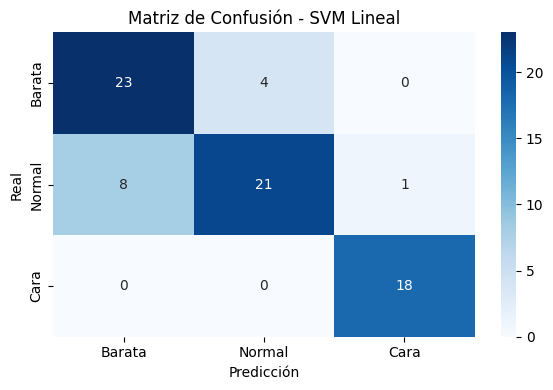

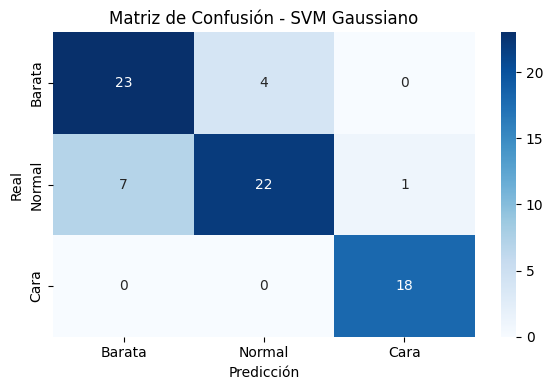

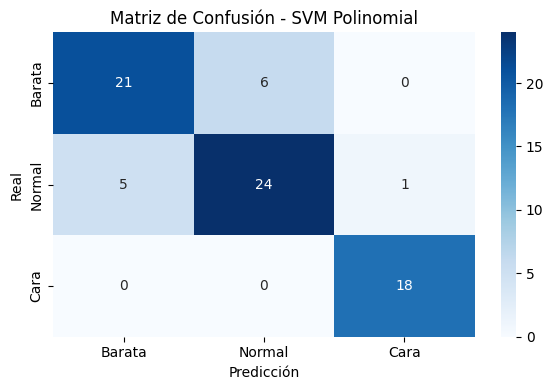

In [42]:
for nombre, grid in mejores_modelos.items():
    y_pred = grid.predict(X_test_clf)
    
    cm = confusion_matrix(y_test_clf, y_pred, labels=["Barata", "Normal", "Cara"])
    
    plt.figure(figsize=(6, 4))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Barata", "Normal", "Cara"],
                yticklabels=["Barata", "Normal", "Cara"])
    plt.title(f"Matriz de Confusión - SVM {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

Al ver los resultados se puede observar que tanto el Kernel Gaussiano, como el polinomial tienen un rendimiento casi idéntico, mientras que el lineal se queda un poco atras. Esto tienen sentido, ya que al ver las gráficas de dispersión, los datos no tienen un comportamiento lineal. A pesar de que el rendimiento es bueno y muy similar en ambos casos, el SVM polinomial tiene un valor más bajo en C, por lo que castiga menos los errores. Esto significa que a la hora de darle valores nuevos y que no se parezcan tanto a los de prueba, es más probable que sea más preciso que el SVM gaussiano.